In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2

In [2]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import pandas as pd

# Load the datasets
daily_logs = pd.read_csv('/content/drive/My Drive/data_users.csv')

# Inspect the data
(daily_logs.head())


,User ID,Date,Dish Name,Sugar
0,1,2014-09-15,"my - McDonalds Espresso Pronto® Flat White, 2 ...",29
1,1,2014-09-15,"Uncle Tobys Australia - Vita Brits, 3 Biscuits...",0
2,1,2014-09-15,"Pauls - Smarter White Milk, 600 ml",34
3,1,2014-09-16,"Gatorade - Lemon-Lime (Australia), 600 ml",36
4,1,2014-09-16,"my - McDonalds Espresso Pronto® Flat White, 2 ...",29


In [4]:
# Preprocess daily and weekly logs
daily_logs['Date'] = pd.to_datetime(daily_logs['Date'])

In [5]:
#preprocess daily logs
def preprocess_logs_day(daily_logs, daily_sugar_limit=50):
    # Aggregate daily sugar intake
    daily_agg = daily_logs.groupby(['User ID', 'Date']).agg({
        'Dish Name': ', '.join, 'Sugar': 'sum'}).reset_index()
    daily_agg.rename(columns={'User ID': 'user_id', 'Sugar': 'daily_sugar_intake', 'Dish Name': 'input_dish'}, inplace=True)

    # Classify sugar levels
    def classify_sugar(sugar):
        if sugar < 0.8 * daily_sugar_limit:
            return 'Low'
        elif sugar <= daily_sugar_limit:
            return 'Normal'
        else:
            return 'High'
    daily_agg['sugar_level'] = daily_agg['daily_sugar_intake'].apply(classify_sugar)

    return daily_agg

In [6]:
daily_agg = preprocess_logs_day(daily_logs)
(daily_agg.head())

,user_id,Date,input_dish,daily_sugar_intake,sugar_level
0,1,2014-09-15,"my - McDonalds Espresso Pronto® Flat White, 2 ...",63,High
1,1,2014-09-16,"Gatorade - Lemon-Lime (Australia), 600 ml, my ...",100,High
2,1,2014-09-17,"my - McDonalds Espresso Pronto® Flat White, 2 ...",105,High
3,1,2014-09-18,"my - McDonalds Espresso Pronto® Flat White, 2 ...",71,High
4,1,2014-09-19,"my - McDonalds Espresso Pronto® Flat White, 2 ...",84,High


In [14]:
# Menentukan fitur dan target
X = daily_agg[['daily_sugar_intake']]  # Fitur
y = daily_agg['sugar_level']            # Target (label)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encoding label untuk klasifikasi
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # 'Low' -> 0, 'Normal' -> 1, 'High' -> 2

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [15]:
def create_model(input_dim, num_classes):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation='relu',kernel_regularizer=l2(0.01)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')  # Softmax for multiclass classification
    ])
    return model

In [21]:
input_dim = X_train.shape[1]  # Number of features
num_classes = len(label_encoder.classes_)  # Number of unique Nutri-Score grades

# Create the model
model = create_model(input_dim, num_classes)

# Compile the model
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',  # Use this for integer-encoded labels
    metrics=['accuracy']
)

# Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)
#Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

Epoch 1/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6943 - loss: 1.0095 - val_accuracy: 0.9118 - val_loss: 0.5184
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9125 - loss: 0.4175 - val_accuracy: 0.9118 - val_loss: 0.2270
Epoch 3/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9138 - loss: 0.2233 - val_accuracy: 0.9213 - val_loss: 0.1665
Epoch 4/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9204 - loss: 0.1816 - val_accuracy: 0.9630 - val_loss: 0.1187
Epoch 5/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9626 - loss: 0.1311 - val_accuracy: 0.9753 - val_loss: 0.0885
Epoch 6/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9708 - loss: 0.1062 - val_accuracy: 0.9943 - val_loss: 0.0692
Epoch 7/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9804 - loss: 0.0849 - val_accuracy: 0.9943 - val_loss: 0.0592
Epoch 8/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9783 - loss: 0.0792 - val_accuracy: 1.

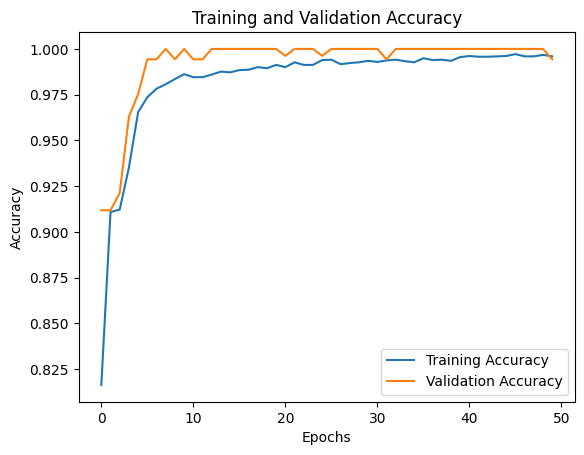

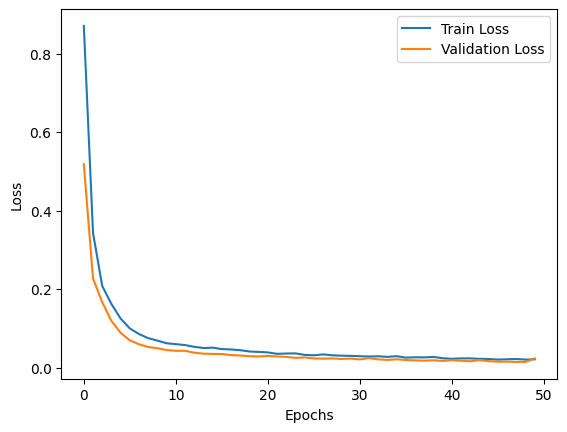

In [22]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
#preprocess weekly logs
def preprocess_logs_week(daily_agg, weekly_sugar_limit=350):

    # Aggregate weekly sugar intake
    daily_agg['Week'] = daily_agg['Date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_agg = daily_agg.groupby(['user_id', 'Week']).agg({
        'input_dish': ', '.join, 'daily_sugar_intake': 'sum'}).reset_index()
    weekly_agg.rename(columns={'daily_sugar_intake': 'weekly_sugar_intake'}, inplace=True)

    # Classify sugar levels
    def classify_sugar(sugar):
        if sugar < 0.8 * weekly_sugar_limit:
            return 'Low'
        elif sugar <= weekly_sugar_limit:
            return 'Normal'
        else:
            return 'High'
    weekly_agg['sugar_level'] = weekly_agg['weekly_sugar_intake'].apply(classify_sugar)

    return weekly_agg

In [25]:
weekly_agg = preprocess_logs_week(daily_agg)
(weekly_agg.head())

,user_id,Week,input_dish,weekly_sugar_intake,sugar_level
0,1,2014-09-15,"my - McDonalds Espresso Pronto® Flat White, 2 ...",667,High
1,1,2014-09-22,"my - McDonalds Espresso Pronto® Flat White, 2 ...",488,High
2,1,2014-09-29,"Gatorade - Lemon-Lime (Australia), 600 ml, Sou...",488,High
3,1,2014-10-06,"my - McDonalds Espresso Pronto® Flat White, 2 ...",586,High
4,1,2014-10-13,"my - McDonalds Espresso Pronto® Flat White, 2 ...",175,Low


In [26]:
# Menentukan fitur dan target
X = weekly_agg[['weekly_sugar_intake']]  # Fitur
y = weekly_agg['sugar_level']            # Target (label)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encoding label untuk klasifikasi
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # 'Low' -> 0, 'Normal' -> 1, 'High' -> 2

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [27]:
input_dim = X_train.shape[1]  # Number of features
num_classes = len(label_encoder.classes_)  # Number of unique Nutri-Score grades

# Create the model
model = create_model(input_dim, num_classes)

# Compile the model
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',  # Use this for integer-encoded labels
    metrics=['accuracy']
)

# Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)
#Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6770 - loss: 1.0855 - val_accuracy: 0.8333 - val_loss: 1.0056
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8577 - loss: 0.9817 - val_accuracy: 0.8488 - val_loss: 0.8721
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8764 - loss: 0.8360 - val_accuracy: 0.8721 - val_loss: 0.6708
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9046 - loss: 0.6394 - val_accuracy: 0.9147 - val_loss: 0.4647
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9144 - loss: 0.4651 - val_accuracy: 0.9341 - val_loss: 0.3379
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9272 - loss: 0.3497 - val_accuracy: 0.9341 - val_loss: 0.2745
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9281 - loss: 0.3091 - val_accuracy: 0.9457 - val_loss: 0.2317
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9264 - loss: 0.2636 - val_accuracy: 0.9457 - val_loss

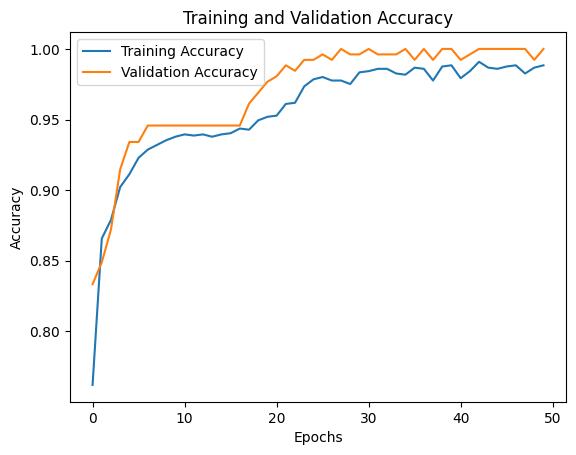

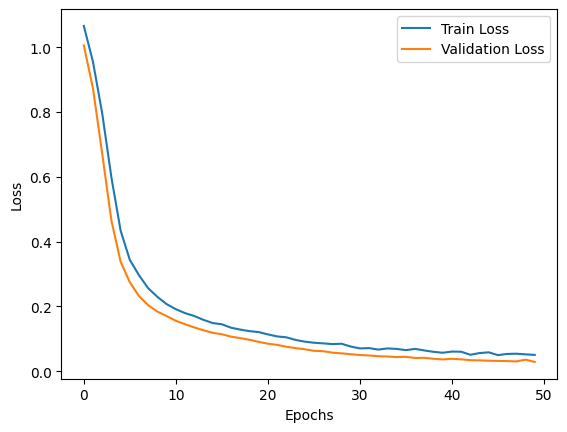

In [28]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
#preprocess monthly logs
def preprocess_logs_month(weekly_agg, monthly_sugar_limit=1500):

    # Aggregate monthly sugar intake
    weekly_agg['Month'] = weekly_agg['Week'].dt.to_period('M').apply(lambda r: r.start_time)
    monthly_agg = weekly_agg.groupby(['user_id', 'Month']).agg({
        'input_dish': ', '.join, 'weekly_sugar_intake': 'sum'}).reset_index()
    monthly_agg.rename(columns={'weekly_sugar_intake': 'monthly_sugar_intake'}, inplace=True)

    # Classify sugar levels
    def classify_sugar(sugar):
        if sugar < 0.8 * monthly_sugar_limit:
            return 'Low'
        elif sugar <= monthly_sugar_limit:
            return 'Normal'
        else:
            return 'High'
    monthly_agg['sugar_level'] = monthly_agg['monthly_sugar_intake'].apply(classify_sugar)

    return monthly_agg

In [36]:
monthly_agg = preprocess_logs_month(weekly_agg)
(monthly_agg.head())

,user_id,Month,input_dish,monthly_sugar_intake,sugar_level
0,1,2014-09-01,"my - McDonalds Espresso Pronto® Flat White, 2 ...",1643,High
1,1,2014-10-01,"my - McDonalds Espresso Pronto® Flat White, 2 ...",761,Low
2,2,2015-01-01,"Brown Toast - Brown Toast With Flora & Jam, 2 ...",1511,High
3,2,2015-02-01,"Own - Banana Medium, 1 piece, Generic - Jacket...",722,Low
4,3,2014-09-01,"Pizza Hut (Canada) - Garlic Bread With Cheese,...",0,Low


In [37]:
# Menentukan fitur dan target
X = monthly_agg[['monthly_sugar_intake']]  # Fitur
y = monthly_agg['sugar_level']            # Target (label)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encoding label untuk klasifikasi
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # 'Low' -> 0, 'Normal' -> 1, 'High' -> 2

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [38]:
input_dim = X_train.shape[1]  # Number of features
num_classes = len(label_encoder.classes_)  # Number of unique Nutri-Score grades

# Create the model
model = create_model(input_dim, num_classes)

# Compile the model
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',  # Use this for integer-encoded labels
    metrics=['accuracy']
)

# Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)
#Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2072 - loss: 1.1404 - val_accuracy: 0.8720 - val_loss: 1.0929
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8186 - loss: 1.0921 - val_accuracy: 0.9760 - val_loss: 1.0417
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9409 - loss: 1.0436 - val_accuracy: 0.9760 - val_loss: 0.9802
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9678 - loss: 0.9831 - val_accuracy: 0.9760 - val_loss: 0.9079
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9574 - loss: 0.9238 - val_accuracy: 0.9760 - val_loss: 0.8203
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9701 - loss: 0.8368 - val_accuracy: 0.9760 - val_loss: 0.7133
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9499 - loss: 0.7479 - val_accuracy: 0.9760 - val_loss: 0.5929
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9662 - loss: 0.6163 - val_accuracy: 0.9760 - val_loss

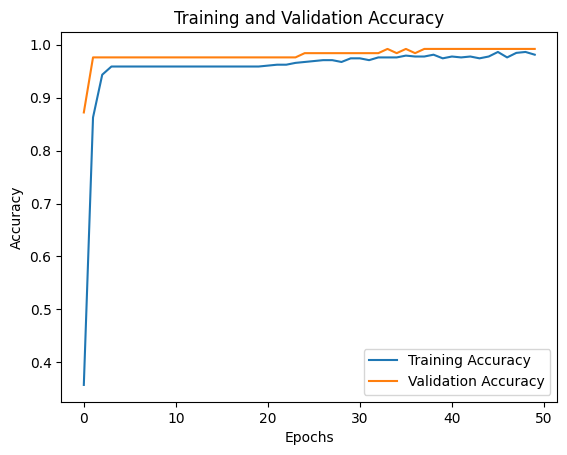

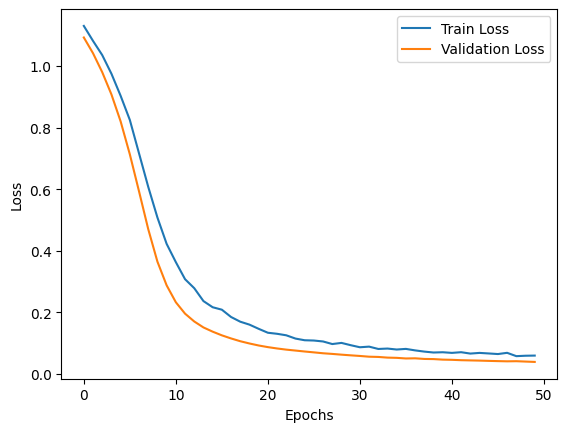

In [39]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()